In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook MORDM will be used to 

In [22]:
# EMA Workbench imports
import ema_workbench
from ema_workbench import (
    Model, Constraint, RealParameter, ScalarOutcome, MultiprocessingEvaluator,
    ema_logging, Constant, Scenario, HypervolumeMetric,
    GenerationalDistanceMetric, EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric, SpacingMetric)
from ema_workbench.em_framework.optimization import (
    EpsilonProgress, to_problem, ArchiveLogger, epsilon_nondominated)
from ema_workbench.analysis import parcoords

# Problem formulation import
from problem_formulation import get_model_for_problem_formulation 
from ema_workbench.em_framework.optimization import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric
)

In [6]:
#Constants
output_dir = 'archives'
scenario_file = './data/Selected_Scenarios.csv'
epsilon_values = [[1e6, 1e6, 1e6, 1e6, 10]]
nfe = 20000
outcomes_of_interest = [
    'Expected Annual Damage',
    'Dike Investment Costs',
    'RfR Investment Costs',
    'Evacuation Costs',
    'Expected Number of Deaths'
]

In [87]:
def run_optimization(epsilon, scenarios, model, seeds=3):
    
    results = []
    convergences = []

    os.makedirs(output_dir, exist_ok=True)

    with MultiprocessingEvaluator(model) as evaluator:
        for scenario in scenarios:
            for seed in range(seeds):
                # Inside run_optimization()
                convergence_metrics = [
                    ArchiveLogger(
                        output_dir,
                        [lever.name for lever in model.levers],
                        [outcome.name for outcome in model.outcomes],
                        base_filename= "optimization.tar.gz"
                    ),
                    EpsilonProgress()
                ]
                # Optimization
                result, convergence = evaluator.optimize(
                    nfe=nfe,
                    searchover="levers",
                    epsilons=epsilon,
                    constraints=None,
                    convergence=convergence_metrics,
                    reference=scenario
                )

                # Filenames
                result_file = os.path.join(output_dir, f"result__scen{scenario.name}__seed{seed}.csv")
                convergence_file = os.path.join(output_dir, f"convergence__scen{scenario.name}__seed{seed}.csv")

                # Output
                result.to_csv(result_file, index=False)
                pd.DataFrame(convergence).to_csv(convergence_file, index=False)

                # Saving Output
                results.append(result)
                convergences.append(convergence)

    return results, convergences

In [88]:
def load_results_from_files(directory):
    """
    Loads all optimization result CSVs from a directory into a single DataFrame.
    """
    results = []
    for filename in os.listdir(directory):
        if filename.startswith("result__") and filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            results.append(df)
    return pd.concat(results, ignore_index=True)


def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [89]:
def load_scenarios(filepath):
    df = pd.read_csv(filepath)
    scenarios = []
    for _, row in df.iterrows():
        name = row['scenario']
        parameters = row.drop(labels='scenario').to_dict()
        scenarios.append(Scenario(name, **parameters))
    return scenarios

In [90]:
def plot_parallel_coordinates(results, eps):
    outcomes = results[outcomes_of_interest]
    limits = parcoords.get_limits(outcomes)
    axes = parcoords.ParallelAxes(limits)
    axes.plot(outcomes)
    plt.title(f'Parallel Coordinates Plot for Epsilon {eps}')
    plt.savefig(f'parallel_coordinates_eps_{eps}.png')
    plt.show()

[MainProcess/INFO] pool started with 24 workers
20010it [06:13, 53.62it/s]                                                     
[MainProcess/INFO] optimization completed, found 230 solutions
20148it [07:08, 47.01it/s]                                                     
[MainProcess/INFO] optimization completed, found 201 solutions
20125it [07:39, 43.83it/s]                                                     
[MainProcess/INFO] optimization completed, found 180 solutions
20058it [08:40, 38.51it/s]                                                     
[MainProcess/INFO] optimization completed, found 252 solutions
20089it [09:07, 36.72it/s]                                                     
[MainProcess/INFO] optimization completed, found 264 solutions
20285it [09:22, 36.08it/s]                                                     
[MainProcess/INFO] optimization completed, found 276 solutions
20143it [08:19, 40.33it/s]                                                     
[MainProcess/I

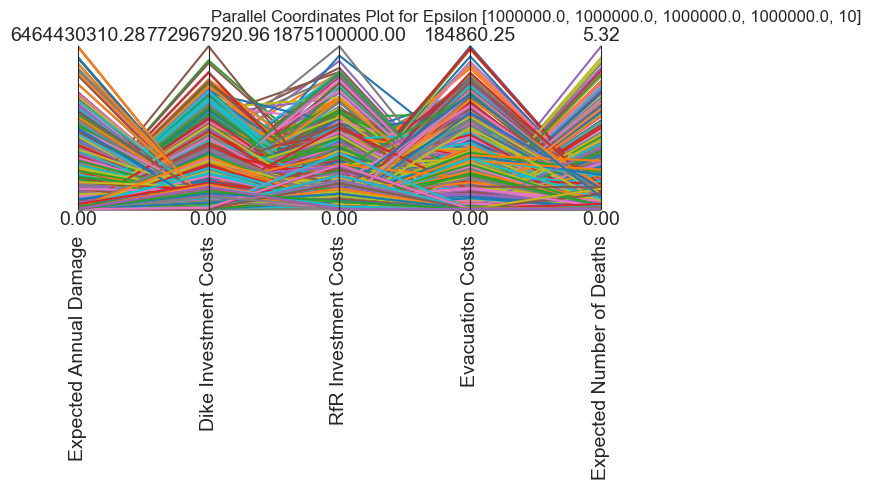

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)

ensure_directory_exists(output_dir)

model, steps = get_model_for_problem_formulation(2)
scenarios = load_scenarios(scenario_file)

for eps in epsilon_values:
    results, convergences = run_optimization(eps, scenarios, model)
    optimization_results = load_results_from_files(output_dir)
    plot_parallel_coordinates(optimization_results, eps)

In [ ]:
print(len(optimization_results))

18550


In [33]:
def get_minimizing_policies(objectives: np.ndarray) -> np.ndarray:
    """
    Return a boolean mask indicating Pareto-optimal (non-dominated) policies.
    Assumes all objectives are to be minimized.
    """
    is_efficient = np.ones(objectives.shape[0], dtype=bool)
    for i, c in enumerate(objectives):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(objectives[is_efficient] < c, axis=1) | np.all(objectives[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

In [34]:
def filter_pareto_optimal_policies(df, objectives):
    """
    Filters a DataFrame to retain only the Pareto-optimal rows (minimization).
    """
    objective_values = df[objectives].values
    pareto_mask = get_minimizing_policies(objective_values)
    return df[pareto_mask]


In [73]:
import glob
archive_files = glob.glob("./archives/archive__scen*__seed*.tar.gz")

archives = {}
for file in archive_files:
    loaded_archives = ArchiveLogger.load_archives(file)
    for key, df in loaded_archives.items():
        if 'Unnamed: 0' in df.columns:
            df = df.drop('Unnamed: 0', axis=1)
        # Use a unique key combining file and key or just append to archives dict
        unique_key = f"{file}__{key}"
        archives[unique_key] = df

# Combine all results into one DataFrame
convergence_results = pd.concat(archives.values(), ignore_index=True)

C:\Users\quint\AppData\Local\Temp\ipykernel_4780\2099686702.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  convergence_results = pd.concat(archives.values(), ignore_index=True)


In [74]:
pareto_results = filter_pareto_optimal_policies(
    all_results, outcomes_of_interest)
pareto_results.to_csv("Pareto_Optimal_Results.csv", index=False)
print("Saved Pareto-optimal policies to pareto_optimal_results.csv")

Saved Pareto-optimal policies to pareto_optimal_results.csv


In [75]:
def calculate_metrics(archives, reference_set):
    """
    Calculate various metrics for a set of archives against a reference set.

    Parameters:
    archives (dict): A dictionary where keys are the number of function evaluations (nfe) 
                     and values are the corresponding archives.
    reference_set (DataFrame): The reference set used for calculating metrics.

    Returns:
    DataFrame: A DataFrame containing the calculated metrics sorted by nfe.
    """
    # Convert the model to an optimization problem
    problem = to_problem(model, searchover="levers")

    # Initialize the metrics using the reference set and the problem
    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    # Initialize an empty list to store the metrics for each archive
    metrics = []

    # Iterate over each archive in the archives dictionary
    for nfe, archive in archives.items():
        # Calculate the scores for each metric
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        # Append the scores to the metrics list
        metrics.append(scores)

    # Convert the list of metrics to a DataFrame
    metrics = pd.DataFrame.from_dict(metrics)

    # Sort the metrics DataFrame by the number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)

    # Return the sorted metrics DataFrame
    return metrics

In [57]:
def plot_metrics(metrics, convergence):
    """
    Plot the convergence and various metrics over the number of function evaluations (nfe).

    Parameters:
    metrics (DataFrame): A DataFrame containing the metrics over nfe.
    convergence (list): A list of convergence objects containing epsilon progress over nfe.
    """
    # Set the style for seaborn plots
    sns.set_style("white")

    # Create a figure with 6 subplots arranged vertically, sharing the x-axis
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    # Unpack the axes for easier reference
    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    # Plot epsilon progress for each convergence object on the first subplot
    for conv in convergence:
        ax1.plot(conv.nfe, conv.epsilon_progress)
    ax1.set_ylabel("$\epsilon$ progress")

    # Plot generational distance on the second subplot
    ax2.plot(metrics.nfe, metrics.generational_distance)
    ax2.set_ylabel("Generational Distance")

    # Plot epsilon indicator on the third subplot
    ax3.plot(metrics.nfe, metrics.epsilon_indicator)
    ax3.set_ylabel("Epsilon Indicator")

    # Plot inverted generational distance on the fourth subplot
    ax4.plot(metrics.nfe, metrics.inverted_gd)
    ax4.set_ylabel("Inverted Generational\nDistance")

    # Plot spacing on the fifth subplot
    ax5.plot(metrics.nfe, metrics.spacing)
    ax5.set_ylabel("Spacing")

    # Plot hypervolume on the sixth subplot
    ax6.plot(metrics.nfe, metrics.hypervolume)
    ax6.set_ylabel("Hypervolume")

    # Set the label for the shared x-axis
    ax6.set_xlabel("Number of Function Evaluations (nfe)")

    # Remove the top and right spines from the plots for a cleaner look
    sns.despine(fig)

<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
C:\Users\quint\AppData\Local\Temp\ipykernel_4780\2368158560.py:21: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_ylabel("$\epsilon$ progress")
